In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import colorsys
import imghdr
import os
import random
import h5py
import keras
from PIL import Image, ImageDraw, ImageFont
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from keras.backend import *
import scipy
import scipy.io
from yad2k.models.keras_darknet19 import *
from yad2k.models.keras_yolo import *

Using TensorFlow backend.


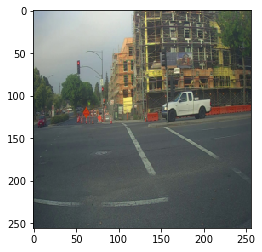

In [4]:
img = np.array(scipy.ndimage.imread('images/0010.jpg',flatten=False))
img = scipy.misc.imresize(img,size=(256,256))
plt.imshow(img)

In [5]:
x = arange(start=0,stop=5)
brr = arange(5)
arr = arange(5)
brr = tile(brr,[5])
arr = flatten(transpose(tile(expand_dims(arr,axis=0),[5,1])))
brr = transpose(stack([brr,arr]))
print(brr)
sess = get_session()
print(sess.run(brr))

Tensor("transpose_1:0", shape=(25, 2), dtype=int32)
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [0 1]
 [1 1]
 [2 1]
 [3 1]
 [4 1]
 [0 2]
 [1 2]
 [2 2]
 [3 2]
 [4 2]
 [0 3]
 [1 3]
 [2 3]
 [3 3]
 [4 3]
 [0 4]
 [1 4]
 [2 4]
 [3 4]
 [4 4]]


In [6]:
def read_classes(file_path):
    
    ptr = open(file_path,'r')
    content = ptr.readlines()
    ans = [c.strip() for c in content]
    ans = np.array(ans)
    
    return ans

In [7]:
def read_anchors(file_path):
    
    ptr = open(file_path,'r')
    content = ptr.readlines()
    ans = []
    for val in content:
        ans.extend([float(c) for c in val.split(',')])
    ans = np.array(ans).reshape(5,2)
    
    return ans

In [8]:
def Create_Box(A,anchors,classes):
    
    num_anchors = len(anchors)
    num_classes = len(classes)
    anchor_tensor = variable(anchors)
    anchor_tensor = reshape(anchor_tensor,[1,1,1,num_anchors,2])
    shape = tf.shape(A)[1:3]
    
    height = arange(start=0,stop=shape[0])
    width = arange(start=0,stop=shape[1])
    height = tile(height,[shape[1]])
    width = flatten(transpose(tile(expand_dims(width,0),[shape[0],1])))
    filter_size = transpose(stack([height,width]))
    filter_size = cast(reshape(filter_size,[1,shape[0],shape[1],1,2]),dtype(A))
    A = reshape(A,[-1,shape[0],shape[1],num_anchors,5+num_classes])
    shape = cast(reshape(shape,[1,1,1,1,2]),dtype(A))
    
    box_confidence = sigmoid(A[...,4:5])
    box_xy = sigmoid(A[...,0:2])
    box_hw = exp(A[...,2:4])
    box_class_probs = softmax(A[...,5:])
    
    box_xy = (box_xy + filter_size)/shape
    box_hw = (box_hw * anchor_tensor)/shape
    
    yolo_outputs = (box_confidence,box_xy,box_hw,box_class_probs)
    
    return yolo_outputs

In [9]:
def filter_boxes(box_confidence,boxes,box_class_probs,score_threshold):
    
    box_scores = tf.multiply(box_confidence,box_class_probs)
    classes = tf.argmax(box_scores,axis=-1)
    scores = tf.reduce_max(box_scores,axis=-1)
    
    filter_mask = scores >= score_threshold
    
    scores = tf.boolean_mask(scores,filter_mask)
    classes = tf.boolean_mask(classes,filter_mask)
    boxes = tf.boolean_mask(boxes,filter_mask)
    
    return scores,boxes,classes

In [10]:
def Non_Max_Suppression(scores,boxes,classes,max_boxes,iou_threshold):
    
    nms_indexes = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)
    scores = gather(scores,nms_indexes)
    boxes= gather(boxes,nms_indexes)
    classes = gather(classes,nms_indexes)
    
    return scores,boxes,classes

In [11]:
def boxes_to_corners(box_xy,box_hw):
    
    box_min = box_xy - (box_hw/2.0)
    box_max = box_xy + (box_hw/2.0) 
    box_min_max = concatenate([box_min[...,1:2],box_min[...,0:1],box_max[...,1:2],box_max[...,0:1]])
    
    return box_min_max

In [12]:
def scale_boxes(boxes,image_shape):
    
    height = image_shape[0]
    width = image_shape[1]
    dim = reshape(stack([height,width,height,width]),[1,4])
    boxes = boxes * dim
    
    return boxes

In [13]:
def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

In [14]:
def Data_Preprocessing(file_path,model_image_size):
    
    image = Image.open(file_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image,dtype='float32')
    image_data /= 255
    image_data = np.expand_dims(image_data,0)
    
    return image,image_data

In [15]:
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = np.maximum(0, np.floor(top + 0.5).astype('int32'))
        left = np.maximum(0, np.floor(left + 0.5).astype('int32'))
        bottom = np.minimum(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = np.minimum(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [16]:
def Model_Helper(yolo_outputs,max_boxes,score_threshold,iou_threshold,image_shape):
    
    (box_confidence,box_xy,box_hw,box_class_probs) = yolo_outputs
    
    boxes = boxes_to_corners(box_xy,box_hw)
    scores,boxes,classes = filter_boxes(box_confidence,boxes,box_class_probs,score_threshold)
    scores,boxes,classes = Non_Max_Suppression(scores,boxes,classes,max_boxes,iou_threshold)
    boxes = scale_boxes(boxes,image_shape)
    
    return scores,boxes,classes

In [29]:
def Model(image_name,max_boxes,score_threshold,iou_threshold):
    
    image_path = "images/"+image_name
    image_shape = (720.,1280.)
    image,image_data = Data_Preprocessing(image_path,(608,608))
    model = load_model("model_data/yolo.h5")
    class_names = read_classes("model_data/coco_classes.txt")
    anchors = read_anchors("model_data/yolo_anchors.txt")
    yolo_outputs = Create_Box(model.output,anchors,class_names)
    
    scores,boxes,classes = Model_Helper(yolo_outputs,max_boxes,score_threshold,iou_threshold,image_shape)
    sess = get_session()
    
    val1,val2,val3 = sess.run([scores,boxes,classes],feed_dict={model.input:image_data,learning_phase():0})
    
    print('Found {} boxes in the image {}'.format(len(val1),image_name))
    colors = generate_colors(class_names)
    draw_boxes(image,val1,val2,val3,class_names,colors)
    image.save(os.path.join("out", image_name), quality=90)
    img = scipy.misc.imread(os.path.join("out",image_name))
    plt.imshow(img)
    
    return val1,val2,val3,model

In [30]:
def Caller_Function():
    
    max_boxes = 10
    score_threshold = 0.6
    iou_threshold = 0.5
    image_name = "0010.jpg"
    
    scores,boxes,classes,model = Model(image_name,max_boxes,score_threshold,iou_threshold)
    model.summary()

/opt/conda/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Found 1 boxes in the image 0010.jpg
truck 0.66 (736, 266) (1054, 368)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 608, 608, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 608, 608, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 608, 608, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 608, 608, 32)  0           batch_normalization_1[0][0]      
_____________________

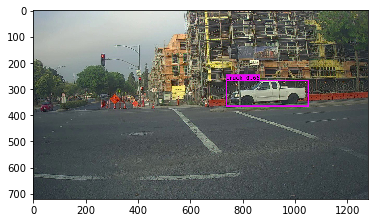

In [31]:
Caller_Function()